In [1]:
!pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 7.4 MB/s 


In [77]:
# Imports
import keras
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
#from sklearn.model_selection import GridSearchCV
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.layers.activation import LeakyReLU

from sklearn.metrics import accuracy_score 
#accuracy_score(y_test, y_pred)

from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, UniversalPerturbation, SaliencyMapMethod
from art.estimators.classification import KerasClassifier

# Set the random seeds. DO NOT CHANGE THIS!
seedVal = 41
random.seed(seedVal)
np.random.seed(seedVal)

# Defining some constants
NUM_CLASSES = 10
BATCH_SIZE = 64

In [3]:
tf.compat.v1.disable_eager_execution()

## Setting up things

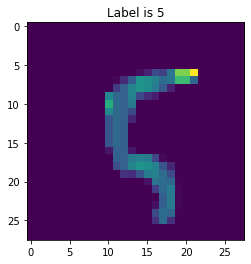

(28, 28)


In [90]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalization
x_train = keras.utils.normalize(x_train, axis=1)
x_test = keras.utils.normalize(x_test, axis=1)

# Plot an example image (after normalization) from the train set
plt.title('Label is {}'.format(y_train[100]))
plt.imshow(x_train[100])
plt.show()
print(x_train[100].shape)
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

K.set_image_data_format('channels_first')
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28)
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)

In [33]:
print(y_train.shape)

(60000, 10)


In [34]:
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [27]:
print(x_train[0:100].shape)

(100, 784)


## Train CNN based model

### You need to complete the following.

In [5]:
#, ReLU
# Define the CNN network architecture. 
cnn_based_model = Sequential()

# Define the intermediate layers.
#None
cnn_based_model.add(Conv2D(32,(3,3),activation='relu',input_shape = (1,28,28),padding='same'))
cnn_based_model.add(Conv2D(64,(3,3),activation='relu',input_shape = (1,28,28),padding='same'))
cnn_based_model.add(MaxPooling2D(pool_size=(2,2),padding='same'))

cnn_based_model.add(Flatten())
cnn_based_model.add(Dense(128, activation='relu'))

cnn_based_model.add(Dense(NUM_CLASSES, activation='softmax'))

In [76]:
# Compile the CNN model. 
None
cnn_based_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_based_classifier = KerasClassifier(model=cnn_based_model, clip_values=(0,1))
cnn_based_classifier.fit(x_train, y_train, nb_epochs=5, batch_size=BATCH_SIZE)

# Get the predictions on the test set.
predictions = cnn_based_model.predict(x_test)

# Compute the accuracy on the test set.
cnn_based_score1 = cnn_based_model.evaluate(x_test,y_test)[1]

print('Test accuracy:', cnn_based_score1)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 6s 99us/sample - loss: 0.0045 - accuracy: 0.9986
Epoch 2/5
60000/60000 [==============================] - 6s 93us/sample - loss: 0.0047 - accuracy: 0.9986
Epoch 3/5
60000/60000 [==============================] - 5s 92us/sample - loss: 0.0021 - accuracy: 0.9994
Epoch 4/5
60000/60000 [==============================] - 5s 91us/sample - loss: 0.0032 - accuracy: 0.9989
Epoch 5/5
60000/60000 [==============================] - 5s 86us/sample - loss: 0.0030 - accuracy: 0.9990


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Test accuracy: 0.9879


In [78]:
cnn_based_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 28, 28)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 28, 28)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 14, 14)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 128)               1605760   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

## Train ANN based model (dense layers only)

### You need to complete the following.

In [37]:
# Define the ANN network architecture.
ann_based_model = Sequential()

# Define the intermediate layers.
None
ann_based_model.add(Dense(input_dim = x_train.shape[1], units = 256, kernel_initializer='uniform', activation='relu'))
#ann_based_model.add(Dense(output_dim = 100, init = 'uniform', activation = 'relu'))
#ann_based_model.add(Dense(units = 10, kernel_initializer='uniform', activation='softmax'))

ann_based_model.add(Dense(NUM_CLASSES, activation='softmax'))

In [38]:
# Compile the ANN model. 
None
ann_based_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [85]:
ann_based_classifier = KerasClassifier(model=ann_based_model, clip_values=(0,1))
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
ann_based_classifier.fit(x_train, y_train, nb_epochs=10, batch_size=BATCH_SIZE)

# Get the predictions on the test set.
predictions = ann_based_classifier.predict(x_test)

# Compute the accuracy on the test set.
ann_score = ann_based_model.evaluate(x_test,y_test,batch_size=BATCH_SIZE)[1]

print('Test accuracy:', ann_score)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 42us/sample - loss: 0.0123 - accuracy: 0.9973
Epoch 2/10
60000/60000 [==============================] - 2s 32us/sample - loss: 0.0102 - accuracy: 0.9975
Epoch 3/10
60000/60000 [==============================] - 2s 32us/sample - loss: 0.0072 - accuracy: 0.9987
Epoch 4/10
60000/60000 [==============================] - 2s 32us/sample - loss: 0.0058 - accuracy: 0.9991
Epoch 5/10
60000/60000 [==============================] - 2s 32us/sample - loss: 0.0044 - accuracy: 0.9992
Epoch 6/10
60000/60000 [==============================] - 2s 32us/sample - loss: 0.0045 - accuracy: 0.9992
Epoch 7/10
60000/60000 [==============================] - 2s 32us/sample - loss: 0.0030 - accuracy: 0.9997
Epoch 8/10
60000/60000 [==============================] - 2s 32us/sample - loss: 0.0045 - accuracy: 0.9991
Epoch 9/10
60000/60000 [==============================] - 2s 32us/sample - loss: 0.0028 - accuracy: 0.9997
Epoch 10/10
60

In [95]:
ann_based_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 256)               200960    
                                                                 
 dense_8 (Dense)             (None, 10)                2570      
                                                                 
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


## Compare the classification accuracy on the test data graphically

### You need to complete the following.

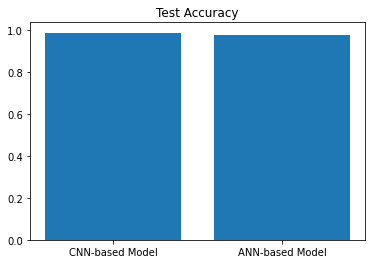

In [86]:
X = ['CNN-based Model','ANN-based Model']
Y = [cnn_based_score1, ann_score]
plt.bar(X, Y)
plt.title('Test Accuracy')
plt.show()
plt.close()

## Part 2: Generate adversarial examples using four methods

### You need to complete the following.

In [74]:
def generate_adv_examples_FGSM(classifier, x):
    # This attack is known as the "Fast Gradient Sign Method".
    attack = FastGradientMethod(classifier)
    x_adv = attack.generate(x)
    return x_adv

def generate_adv_examples_BasicIterativeMethod(classifier, x):
    # The Basic Iterative Method is the iterative version of FGM and FGSM.
    attack = BasicIterativeMethod(classifier)
    x_adv = attack.generate(x)
    return x_adv

def generate_adv_examples_SaliencyMapMethod(classifier, x):
    # attack from the Jacobian-based Saliency Map Attack (Papernot et al. 2016).
    # Paper link: https://arxiv.org/abs/1511.07528
    attack = SaliencyMapMethod(classifier)
    x_adv = attack.generate(x)
    return x_adv

def generate_adv_examples_UniversalPerturbation(classifier, x):
    attack = UniversalPerturbation(classifier)
    x_adv = attack.generate(x)
    return x_adv

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

JSMA:   0%|          | 0/100 [00:00<?, ?it/s]

Universal perturbation:   0%|          | 0/20 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

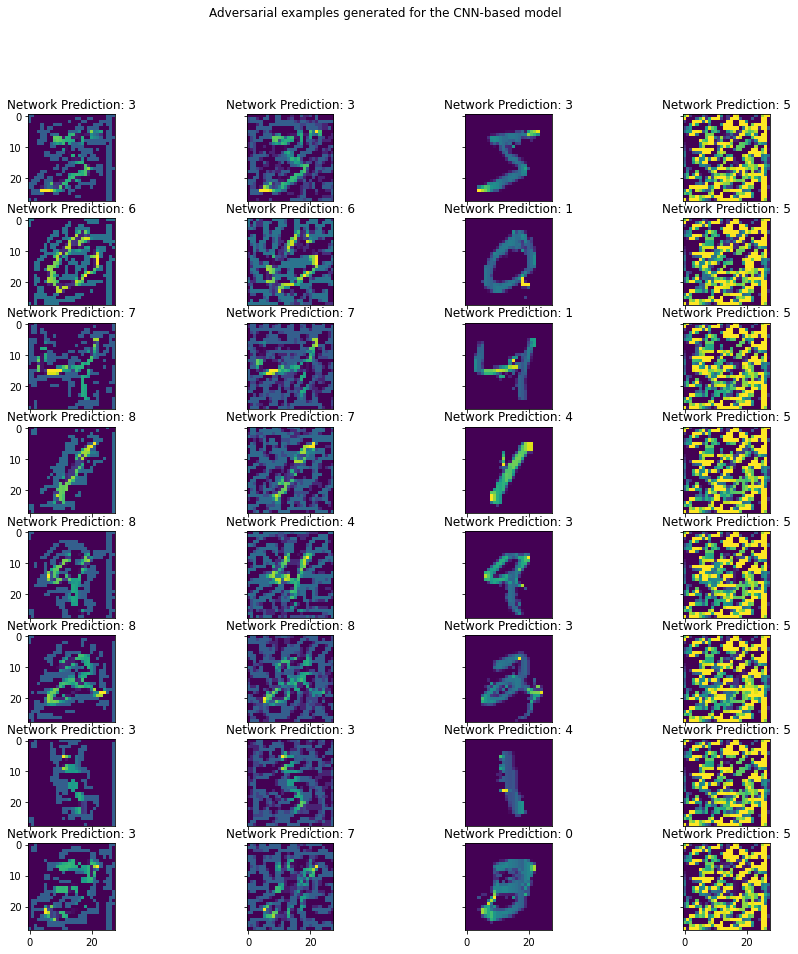

In [80]:
# Generate examples for CNN-based model
x = x_train[0:100]
classifier = cnn_based_classifier

cnn_adv_examples_FGSM = generate_adv_examples_FGSM(classifier, x)
cnn_adv_examples_BasicIterativeMethod = generate_adv_examples_BasicIterativeMethod(classifier, x)
cnn_adv_examples_SaliencyMapMethod = generate_adv_examples_SaliencyMapMethod(classifier, x)
cnn_adv_examples_UniversalPerturbation = generate_adv_examples_UniversalPerturbation(classifier, x)

# Generate plot
fig, ax = plt.subplots(8, 4, sharex='col', sharey='row', figsize=(15,15))
fig.suptitle('Adversarial examples generated for the CNN-based model')
cnn_adv_examples = [cnn_adv_examples_FGSM,cnn_adv_examples_BasicIterativeMethod,cnn_adv_examples_SaliencyMapMethod,cnn_adv_examples_UniversalPerturbation]

for i in range(8):
    for j in range(4):
        ax[i, j].imshow(cnn_adv_examples[j][i].squeeze())
        predictions = cnn_based_classifier.predict(np.expand_dims(cnn_adv_examples[j][i], 0))
        ax[i, j].set_title('Network Prediction: {}'.format(np.argmax(predictions)))

In [46]:
print(cnn_adv_examples_BasicIterativeMethod.shape )

(100, 1, 28, 28)


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

JSMA:   0%|          | 0/100 [00:00<?, ?it/s]

Universal perturbation:   0%|          | 0/20 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

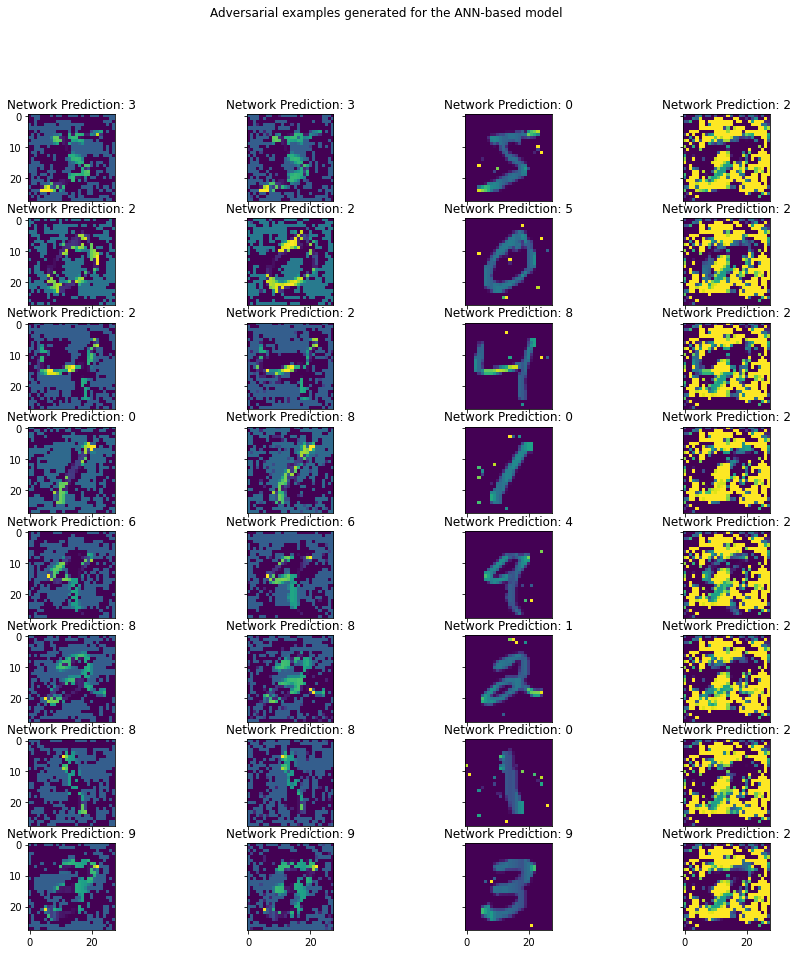

In [47]:
# Generate examples for ANN-based model
x = x_train[0:100]
x = x.reshape(100, 784)
classifier = ann_based_classifier

ann_adv_examples_FGSM = generate_adv_examples_FGSM(classifier, x)
ann_adv_examples_BasicIterativeMethod = generate_adv_examples_BasicIterativeMethod(classifier, x)
ann_adv_examples_SaliencyMapMethod = generate_adv_examples_SaliencyMapMethod(classifier, x)
ann_adv_examples_UniversalPerturbation = generate_adv_examples_UniversalPerturbation(classifier, x)

# Generate plots
fig, ax = plt.subplots(8, 4, sharex='col', sharey='row', figsize=(15,15))
fig.suptitle('Adversarial examples generated for the ANN-based model')
ann_adv_examples = [ann_adv_examples_FGSM.reshape(100, 28, 28),ann_adv_examples_BasicIterativeMethod.reshape(100, 28, 28),ann_adv_examples_SaliencyMapMethod.reshape(100, 28, 28),ann_adv_examples_UniversalPerturbation.reshape(100, 28, 28)]

for i in range(8):
    for j in range(4):
        ax[i, j].imshow(ann_adv_examples[j][i].squeeze())
        predictions = ann_based_classifier.predict(np.expand_dims(ann_adv_examples[j][i].reshape( 784), 0))
        ax[i, j].set_title('Network Prediction: {}'.format(np.argmax(predictions)))

In [48]:
xe = ann_adv_examples_FGSM.reshape(100,28,28)
print(xe[0].shape)

(28, 28)


## Part 3: Create a new test set, based entirely on the adversarial images generated previously. Test your classifiers performance on this test set.

### You need to complete the following.

In [81]:
# We will be using the FGSM method in this part
x1 = x_test[0:10000]
classifier = cnn_based_classifier
cnn_adv_examples_FGSM = generate_adv_examples_FGSM(classifier, x1)
x2 = x_test[0:10000]
x2 = x2.reshape(10000, 784)
classifier2 = ann_based_classifier
ann_adv_examples_FGSM = generate_adv_examples_FGSM(classifier2, x2)

In [87]:
# Evaluate ANN-based-classifier on the newly generated adversarial test set
predictions = ann_based_classifier.predict(ann_adv_examples_FGSM)
ann_based_score = ann_based_model.evaluate(ann_adv_examples_FGSM, y_test)[1]
print('ANN-based Model Score: {}'.format(ann_based_score))

ANN-based Model Score: 0.016200000420212746


In [83]:
# Evaluate CNN-based-classifier on the newly generated adversarial test set
predictions = cnn_based_classifier.predict(cnn_adv_examples_FGSM)
cnn_based_score2 = cnn_based_model.evaluate(cnn_adv_examples_FGSM, y_test)[1]
print('CNN-based Model Score: {}'.format(cnn_based_score2))

CNN-based Model Score: 0.1542000025510788


In [52]:
print(ann_adv_examples_FGSM.shape)
print(x_train.shape)

(10000, 784)
(60000, 1, 28, 28)


In [53]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

## Create a new augmented test set (original test images + adversarial images)


### You need to complete the following.

In [88]:
# ANN-based-classifier
ann_augmented_examples = []
for i in range(10000):
    
    # Select adversarial samples.
    if random.randint(0, 1) == 0:
        ann_augmented_examples.append(ann_adv_examples_FGSM[i])
    # Select actual samples.
    else:
        ann_augmented_examples.append(x_test[i])
        
#ann_augmented_examples = np.concatenate(ann_augmented_examples, axis=0)
#print(ann_augmented_examples.shape)

predictions = ann_based_classifier.predict(ann_augmented_examples)
ann_based_score2 = ann_based_model.evaluate(x_test, predictions)[1]
print('ANN-based Model Score: {}'.format(ann_based_score2))

ANN-based Model Score: 0.503600001335144


In [91]:
# CNN-based-classifier
cnn_augmented_examples = []
for i in range(10000):
    
    # Select adversarial samples.
    if random.randint(0, 1) == 0:
        cnn_augmented_examples.append(cnn_adv_examples_FGSM[i])
    # Select actual samples.
    else:
        cnn_augmented_examples.append(x_test[i])

#cnn_augmented_examples = np.concatenate(cnn_augmented_examples, axis=0)

predictions = cnn_based_classifier.predict(cnn_augmented_examples)
cnn_based_score3 = cnn_based_model.evaluate(x_test, predictions)[1]
print('CNN-based Model Score: {}'.format(cnn_based_score3))

CNN-based Model Score: 0.5741000175476074


## Make a single plot, wherein you compare the test accuracies of all the models, on the three types of test sets that you have

### You need to complete the following.

In [92]:
cnn_models_score = [cnn_based_score1, cnn_based_score3, cnn_based_score2]
ann_models_score = [ann_score, ann_based_score2, ann_based_score]

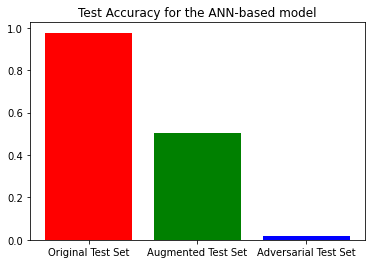

In [93]:
# Plot for the ANN based model.
X = ['Original Test Set','Augmented Test Set', 'Adversarial Test Set']
plt.bar(X, ann_models_score, color=['r', 'g', 'b'])
plt.title('Test Accuracy for the ANN-based model')
plt.show()
plt.close()

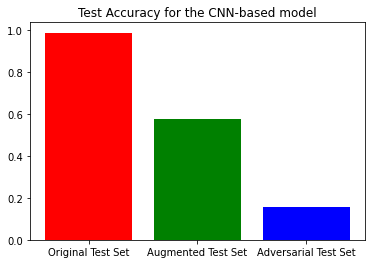

In [94]:
# Plot for the CNN based model.
X = ['Original Test Set','Augmented Test Set', 'Adversarial Test Set']
plt.bar(X, cnn_models_score , color=['r', 'g', 'b'])
plt.title('Test Accuracy for the CNN-based model')
plt.show()
plt.close()